# Multiple Linear Regression Assignment

In [34]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [35]:
# Reading the dataset
df = pd.read_csv('day.csv')
print(df.shape)
df.head()

(730, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


##### Dropping these columns-
##### instant - index column
##### dteday - derived columns (year, month, weekday) are already given
##### We are not looking to predict the number of casual or registered users individually;
##### A sum of these two columns is already in the cnt column; Hence dropping casal and registered

In [36]:
df.drop(['instant','dteday','casual','registered'], axis=1, inplace=True)
df.shape

(730, 12)

In [37]:
df.info()
# No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


In [38]:
df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


temp


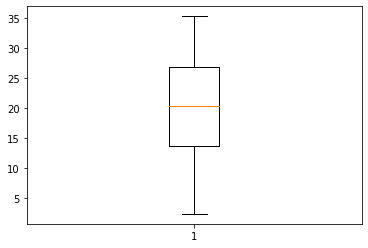

atemp


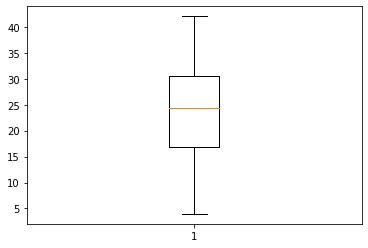

hum


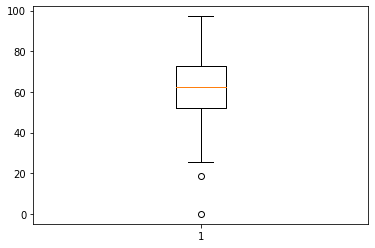

windspeed


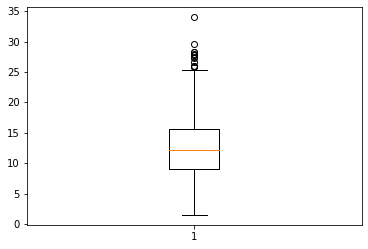

cnt


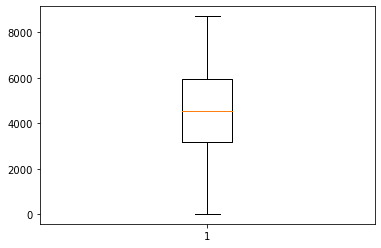

In [39]:
# Checking for outliers using boxplots
for i in ['temp', 'atemp', 'hum','windspeed', 'cnt']:
    print(i)
    plt.boxplot(df[i])
    plt.show()

In [40]:
# Relacing outliers in windspeed col
df['windspeed'].clip(upper = 25, inplace=True)

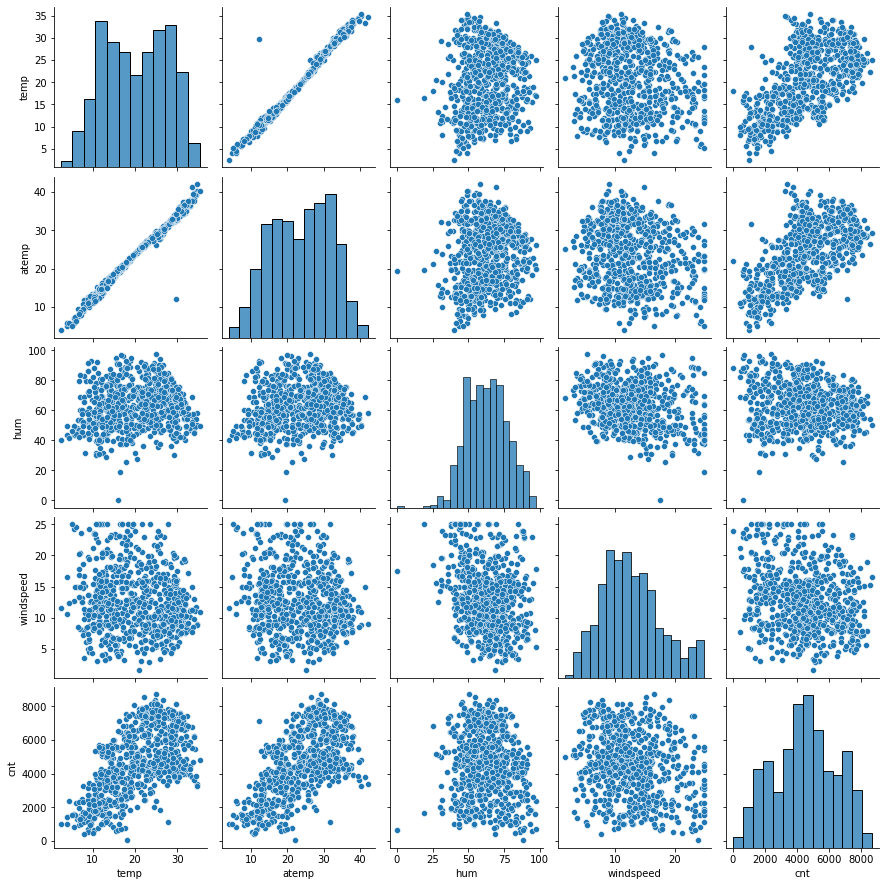

In [41]:
# Checking for linearity of numeric columns
sns.pairplot(df[['temp','atemp','hum','windspeed','cnt']])
plt.show()

#####  We can observe linear relationship between teperatures and cnt

In [42]:
# season : season (1:spring, 2:summer, 3:fall, 4:winter)

# weathersit : 
# 1: Clear, Few clouds, Partly cloudy, Partly cloudy
# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

def num_to_str_col(col, num):
    '''
    Function to change the non ordinal columns to string columns
    '''
    if num == 0:
        if col == 1:
            return 'spring'
        elif col == 2:
            return 'summer'
        elif col == 3:
            return 'fall'
        else:
            return 'winter'
    else:
        if col == 1:
            return 'Clear'
        elif col == 2:
            return 'Mist_Cloudy'
        elif col == 3:
            return 'Light_Snow'
        else:
            return 'Heavy_Rain'

In [43]:
# Replace the numbers in season and weathersit column back to str. Currently ordinal, which does not prove any order
df['season'] = df['season'].apply(lambda x : num_to_str_col(x,0))
df['weathersit'] = df['weathersit'].apply(lambda x : num_to_str_col(x,1))

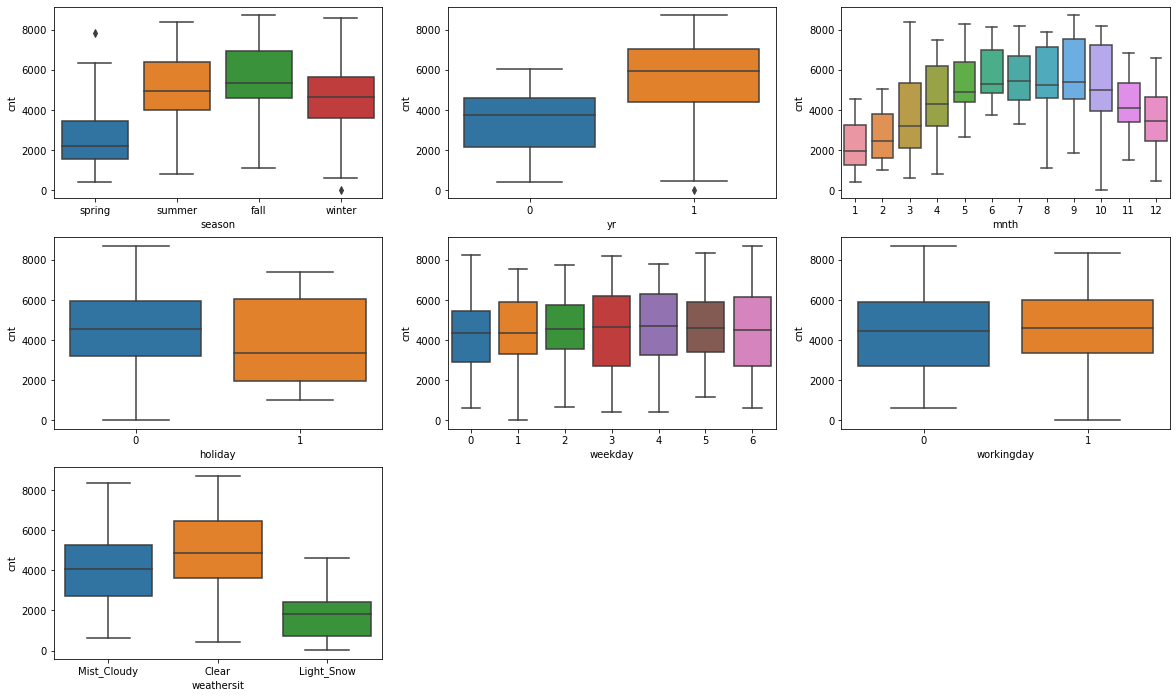

In [44]:
# checking correlation for categorical columns

plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = df)
plt.subplot(3,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = df)
plt.subplot(3,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = df)
plt.subplot(3,3,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = df)
plt.subplot(3,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = df)
plt.subplot(3,3,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = df)
plt.subplot(3,3,7)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df)
plt.show()

###### From the bx plots We observe that the demand for cycles is 
###### - Higher year on year
###### - Higher during clear weathers
###### - Higher during fall season (Sept month)

In [45]:
# Convert categorical to numerical
season = pd.get_dummies(df['season'], drop_first = True)
weathersit = pd.get_dummies(df['weathersit'], drop_first = True)
boombikes = pd.concat([df, season, weathersit], axis = 1)

In [46]:
boombikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,spring,summer,winter,Light_Snow,Mist_Cloudy
0,spring,0,1,0,6,0,Mist_Cloudy,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,1
1,spring,0,1,0,0,0,Mist_Cloudy,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,1
2,spring,0,1,0,1,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0
3,spring,0,1,0,2,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0
4,spring,0,1,0,3,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0


In [47]:
# dropping since we have created dummies
boombikes.drop(['season', 'weathersit'], axis=1, inplace=True)

In [48]:
# Train test split

np.random.seed(0)
df_train, df_test = train_test_split(boombikes, train_size = 0.7, test_size = 0.3, random_state = 100)
print(boombikes.shape, df_train.shape, df_test.shape)

(730, 15) (510, 15) (219, 15)


In [49]:
df_train.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,Light_Snow,Mist_Cloudy
653,1,10,0,2,1,19.201653,23.0423,55.8333,12.208807,7534,0,0,1,0,0
576,1,7,0,2,1,29.246653,33.1448,70.4167,11.083475,7216,0,0,0,0,0
426,1,3,0,6,0,16.980847,20.6746,62.1250,10.792293,4066,1,0,0,0,1
728,1,12,0,0,0,10.489153,11.5850,48.3333,23.500518,1796,1,0,0,0,0
482,1,4,0,6,0,15.443347,18.8752,48.9583,8.708325,4220,0,1,0,0,1


In [50]:
# Scaling

scaler = MinMaxScaler()
col = ['mnth', 'weekday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']

df_train[col] = scaler.fit_transform(df_train[col])

In [51]:
df_train.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,Light_Snow,Mist_Cloudy
653,1,0.818182,0,0.333333,1,0.509887,0.501133,0.575354,0.422926,0.864243,0,0,1,0,0
576,1,0.545455,0,0.333333,1,0.815169,0.766351,0.725633,0.372157,0.827658,0,0,0,0,0
426,1,0.181818,0,1.000000,0,0.442393,0.438975,0.640189,0.359021,0.465255,1,0,0,0,1
728,1,1.000000,0,0.000000,0,0.245101,0.200348,0.498067,0.932351,0.204096,1,0,0,0,0
482,1,0.272727,0,1.000000,0,0.395666,0.391735,0.504508,0.265002,0.482973,0,1,0,0,1


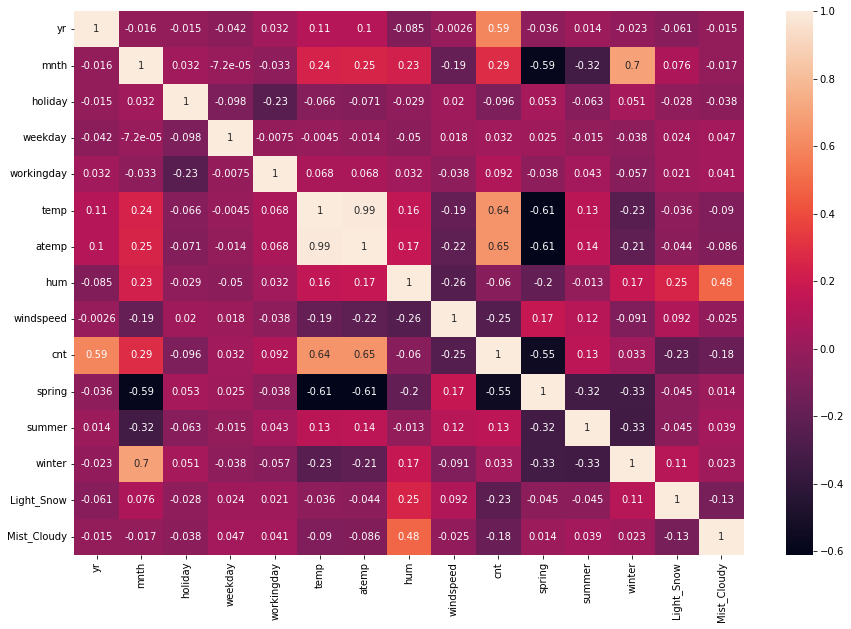

In [52]:
# Looking at correlations

plt.figure(figsize = (15, 10))
sns.heatmap(df_train.corr(), annot = True)
plt.show()

In [53]:
def vif_cols(x_train_consider):
    '''
    Function to calculate the VIF between columns
    '''
    vif = pd.DataFrame()
    vif['Features'] = x_train_consider.columns
    vif['VIF'] = [variance_inflation_factor(x_train_consider.values, i) for i in range(x_train_consider.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def linear_model(col):
    '''
    Function to fit the ols model with features
    '''
    x_train_consider = X_train[col]

    # Add a constant
    X_train_lm = sm.add_constant(x_train_consider)

    # Create a first fitted model
    lr = sm.OLS(y_train, X_train_lm).fit()

    print(lr.summary())
    return x_train_consider, lr, X_train_lm

In [54]:
# Splitting y and x variables
y_train = df_train.pop('cnt')
X_train = df_train

##### 'atemp' has a comparetively high correlation with 'cnt'
##### so linear regression starting with atemp

In [55]:
cols=['atemp']
x_train_consider, lr, X_train_lm = linear_model(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     364.7
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           1.10e-61
Time:                        09:20:12   Log-Likelihood:                 176.51
No. Observations:                 510   AIC:                            -349.0
Df Residuals:                     508   BIC:                            -340.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1629      0.020      8.199      0.0

##### Significant p value but r2 cn be improved

##### adding yr column which has the next highest correlation after atemp

In [56]:
cols = ['atemp', 'yr']
x_train_consider, lr, X_train_lm= linear_model(cols)
vif_cols(x_train_consider)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     579.5
Date:                Tue, 15 Mar 2022   Prob (F-statistic):          1.07e-131
Time:                        09:20:12   Log-Likelihood:                 341.87
No. Observations:                 510   AIC:                            -677.7
Df Residuals:                     507   BIC:                            -665.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0721      0.015      4.810      0.0

,Features,VIF
0,atemp,1.89
1,yr,1.89


##### Adding spring column with -ve correlation to see p and r2

In [57]:
cols = ['atemp', 'yr', 'spring']
x_train_consider, lr, X_train_lm = linear_model(cols)
vif_cols(x_train_consider)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     482.6
Date:                Tue, 15 Mar 2022   Prob (F-statistic):          5.58e-148
Time:                        09:20:12   Log-Likelihood:                 383.02
No. Observations:                 510   AIC:                            -758.0
Df Residuals:                     506   BIC:                            -741.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1942      0.019     10.238      0.0

,Features,VIF
1,yr,1.99
0,atemp,1.89
2,spring,1.12


##### from categorical visualisation, we observed oct nov had high demand, including demand to see how the model behaves

In [58]:
cols = ['atemp', 'yr', 'spring', 'mnth']
x_train_consider, lr, X_train_lm = linear_model(cols)
vif_cols(x_train_consider)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     364.0
Date:                Tue, 15 Mar 2022   Prob (F-statistic):          3.17e-147
Time:                        09:20:13   Log-Likelihood:                 384.47
No. Observations:                 510   AIC:                            -758.9
Df Residuals:                     505   BIC:                            -737.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1677      0.025      6.839      0.0

,Features,VIF
0,atemp,4.07
3,mnth,3.36
1,yr,2.01
2,spring,1.15


##### from categorical visualisation, we observed weather also impacted demand

In [59]:
cols = ['atemp', 'yr', 'spring', 'mnth', 'Light_Snow']
x_train_consider, lr, X_train_lm = linear_model(cols)
vif_cols(x_train_consider)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     354.7
Date:                Tue, 15 Mar 2022   Prob (F-statistic):          1.83e-162
Time:                        09:20:13   Log-Likelihood:                 423.09
No. Observations:                 510   AIC:                            -834.2
Df Residuals:                     504   BIC:                            -808.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1854      0.023      8.117      0.0

,Features,VIF
0,atemp,4.07
3,mnth,3.42
1,yr,2.01
2,spring,1.15
4,Light_Snow,1.04


##### dropping month because of higher vif

In [61]:
cols = ['atemp', 'yr', 'spring', 'Light_Snow']
x_train_consider, lr, X_train_lm = linear_model(cols)
vif_cols(x_train_consider)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     438.6
Date:                Tue, 15 Mar 2022   Prob (F-statistic):          9.97e-163
Time:                        09:20:13   Log-Likelihood:                 420.56
No. Observations:                 510   AIC:                            -831.1
Df Residuals:                     505   BIC:                            -809.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2176      0.018     12.203      0.0

,Features,VIF
1,yr,1.99
0,atemp,1.92
2,spring,1.12
3,Light_Snow,1.02


##### dropping and adding new weather and season features to find the best possible r2 and significant p values

In [62]:
cols = ['atemp', 'yr', 'spring','Light_Snow','Mist_Cloudy']
x_train_consider, lr, X_train_lm = linear_model(cols)
vif_cols(x_train_consider)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     404.0
Date:                Tue, 15 Mar 2022   Prob (F-statistic):          1.05e-173
Time:                        09:20:13   Log-Likelihood:                 449.33
No. Observations:                 510   AIC:                            -886.7
Df Residuals:                     504   BIC:                            -861.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2575      0.018     14.599      

,Features,VIF
0,atemp,2.21
1,yr,1.99
4,Mist_Cloudy,1.43
2,spring,1.17
3,Light_Snow,1.03


In [63]:
cols = ['atemp', 'yr', 'spring', 'Light_Snow']
x_train_consider, lr, X_train_lm = linear_model(cols)
vif_cols(x_train_consider)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     438.6
Date:                Tue, 15 Mar 2022   Prob (F-statistic):          9.97e-163
Time:                        09:20:13   Log-Likelihood:                 420.56
No. Observations:                 510   AIC:                            -831.1
Df Residuals:                     505   BIC:                            -809.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2176      0.018     12.203      0.0

,Features,VIF
1,yr,1.99
0,atemp,1.92
2,spring,1.12
3,Light_Snow,1.02


In [64]:
cols = ['atemp', 'yr', 'spring','Light_Snow','Mist_Cloudy']
x_train_consider, lr, X_train_lm = linear_model(cols)
vif_cols(x_train_consider)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     404.0
Date:                Tue, 15 Mar 2022   Prob (F-statistic):          1.05e-173
Time:                        09:20:13   Log-Likelihood:                 449.33
No. Observations:                 510   AIC:                            -886.7
Df Residuals:                     504   BIC:                            -861.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2575      0.018     14.599      

,Features,VIF
0,atemp,2.21
1,yr,1.99
4,Mist_Cloudy,1.43
2,spring,1.17
3,Light_Snow,1.03


##### r2 is 80% 
##### p values are significant
##### variables are not highly correlated (VIF < 3)

In [65]:
# Pedicting train y
y_train_cnt = lr.predict(X_train_lm)

## Residual Analysis

Text(0.5, 0, 'Errors')

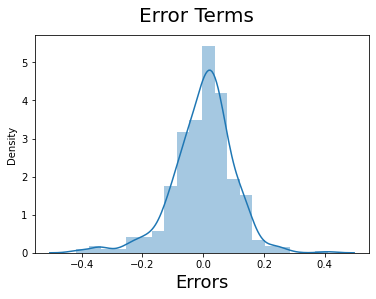

In [66]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)                        

Text(0.5, 0.98, 'Pattern of error terms')

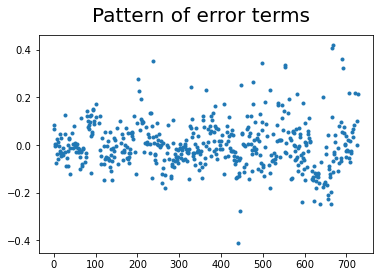

In [67]:
# checking for patterns in error terms - random
res_er = y_train_cnt - y_train
res_er.plot(style='.')
plt.suptitle('Pattern of error terms', fontsize = 20)


#### The cycle demand can be explained majorly by these variables - 
#### atemp - The temperature which an individual experiences definelty impacts if they would cycle or no. Higher or lower temperatures
#### with see lower demand
#### yr - The overall sales every year is a definate parameter to consider for the upcomming yera's prediction
#### Spring - A lot of people go vacation/travelling during spring, which would result in fewer cycle demand considering that the cycle 
#### demand is greater on working days
#### Weather will also influence demand

# Predictions on test data

In [68]:
# Scaling the test variables

col = ['mnth', 'weekday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
df_test[col] = scaler.transform(df_test[col])

In [69]:
df_test.describe()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,Light_Snow,Mist_Cloudy
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.479452,0.497717,0.036530,0.503044,0.698630,0.558941,0.532991,0.638508,0.439371,0.520592,0.255708,0.264840,0.232877,0.027397,0.319635
std,0.500722,0.311080,0.188034,0.331402,0.459904,0.233698,0.217888,0.148974,0.221489,0.218435,0.437258,0.442259,0.423633,0.163612,0.467403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.060189,0.048205,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.272727,0.000000,0.166667,0.000000,0.354650,0.344751,0.527265,0.279121,0.377531,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.454545,0.000000,0.500000,1.000000,0.558691,0.549198,0.627737,0.421049,0.524275,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.727273,0.000000,0.833333,1.000000,0.759096,0.714132,0.743928,0.566700,0.672745,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,1.000000,0.963300,1.000000,1.000000,1.000000,1.000000,1.000000


In [70]:
# Splittng x and y variables

y_test = df_test.pop('cnt')
X_test = df_test

In [71]:
X_test_mlr = sm.add_constant(X_test)

In [72]:
# Predicting test data

X_test_mlr = X_test_mlr[['const', 'atemp', 'yr', 'spring','Light_Snow','Mist_Cloudy']]
y_pred_mlr = lr.predict(X_test_mlr)

Text(0, 0.5, 'y_pred_mlr')

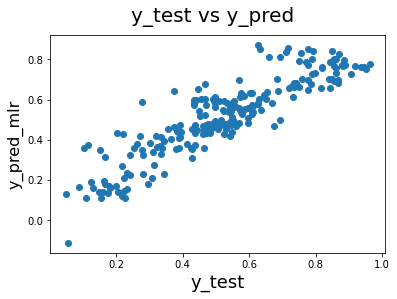

In [73]:
# Checking actuals vs predicted of test data

fig = plt.figure()
plt.scatter(y_test, y_pred_mlr)
fig.suptitle('y_test vs y_pred', fontsize = 20)
plt.xlabel('y_test', fontsize = 18)                         
plt.ylabel('y_pred_mlr', fontsize = 16)  

In [74]:
# r2 for pred values

print('r2 of test data : ',r2_score(y_test, y_pred_mlr))

r2 of test data :  0.7957584808488449


### The r2 of predictions is 79%, which is very close to the train r2. So our model is giving us pretty good results

### y = 0.2575(const) + 0.4064(atemp) + 0.2357(yr) - 0.1581(spring) - 0.2800(Light_Snow) - 0.0740(Mist_Cloudy)